In [1]:
import pandas
from sklearn import (decomposition, preprocessing)
import numpy
import flowio
import seaborn
import matplotlib.pyplot as plt

In [32]:
fcs_data = flowio.FlowData('features.fcs')
npy_data = numpy.reshape(fcs_data.events, (-1, fcs_data.channel_count))
df = pandas.DataFrame(npy_data, columns=[c["PnN"] for c in fcs_data.channels.values()])

In [33]:
df.columns = ["feat_%s" % col if col not in ["set", "label"] else "meta_%s" % col for col in df]
df["index"] = numpy.arange(df.shape[0])

In [34]:
df = df[df["meta_label"] != -1]

In [29]:
dfs = []
for idx, gdf in df.groupby("meta_set"):
    X = gdf.drop(columns=["meta_set", "meta_label"])
    tmp_df = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(X), columns=X.columns)
    tmp_df["meta_set"] = gdf["meta_set"].values
    tmp_df["meta_label"] = gdf["meta_label"].values
    dfs.append(tmp_df)
trans_df = pandas.concat(dfs)
trans_df.loc[trans_df["meta_set"] == 100, "meta_set"] = 1

In [30]:
trans = decomposition.PCA(n_components=2).fit_transform(trans_df.drop(columns=["meta_set", "meta_label"]).values)

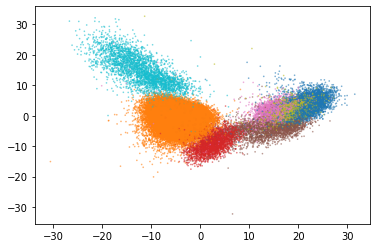

In [31]:
plt.scatter(trans[:, 0], trans[:, 1], s=0.5, alpha=0.5, c=trans_df["meta_label"], cmap="tab10")

In [7]:
import umap

In [8]:
u = umap.UMAP(n_components=2)
u_trans = u.fit_transform(trans_df.drop(columns=["meta_set", "meta_label"]).values)

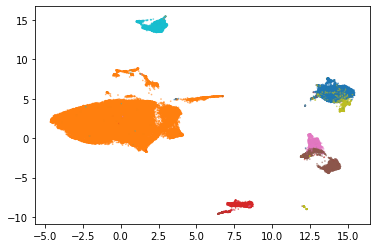

In [9]:
plt.scatter(u_trans[:, 0], u_trans[:, 1], s=0.5, alpha=0.5, c=trans_df["meta_label"], cmap="tab10")

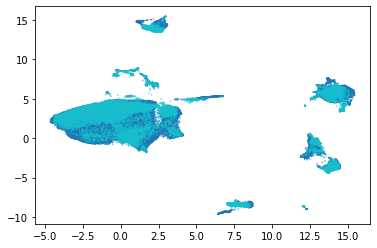

In [10]:
plt.scatter(u_trans[:, 0], u_trans[:, 1], s=0.5, alpha=0.5, c=trans_df["meta_set"], cmap="tab10")

In [11]:
from sklearn.manifold import TSNE

In [12]:
t = TSNE()
t_trans = t.fit_transform(trans_df.drop(columns=["meta_set", "meta_label"]).values)

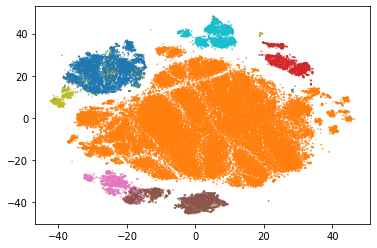

In [44]:
plt.scatter(t_trans[:, 0], t_trans[:, 1], s=0.5, alpha=0.5, c=trans_df["meta_label"], cmap="tab10")

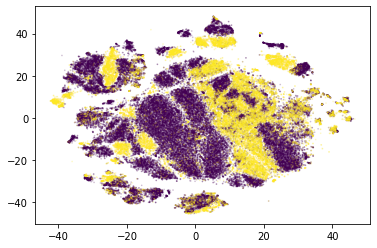

In [45]:
plt.scatter(t_trans[:, 0], t_trans[:, 1], s=0.5, alpha=0.2, c=trans_df["meta_set"])

In [35]:
import pymde

In [36]:
mde_nn = pymde.preserve_neighbors(df.drop(columns=["meta_set", "meta_label"]).values, constraint=pymde.Standardized(), device="cuda", verbose=True)

Jun 23 10:19:47 AM: Computing 15-nearest neighbors, with max_distance=None
Wed Jun 23 10:19:47 2021 Building RP forest with 22 trees
Wed Jun 23 10:19:48 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Jun 23 10:19:50 AM: Computing quadratic initialization.


In [37]:
m_trans = mde_nn.embed(verbose=True, max_iter=1000)

Jun 23 10:19:55 AM: Fitting a standardized embedding into R^2, for a graph with 80654 items and 1237547 edges.
Jun 23 10:19:55 AM: `embed` method parameters: eps=1.0e-05, max_iter=1000, memory_size=10
Jun 23 10:19:55 AM: iteration 0000 | distortion 0.323819 | residual norm 0.0676891 | step length 0.160411 | percent change 0.00270349
Jun 23 10:19:58 AM: iteration 0100 | distortion 0.124036 | residual norm 4.19947e-05 | step length 1 | percent change 0.150598
Jun 23 10:20:01 AM: iteration 0200 | distortion 0.123699 | residual norm 1.69492e-05 | step length 1 | percent change 0.248376
Jun 23 10:20:03 AM: Converged in 281 iterations, with residual norm 9.50614e-06
Jun 23 10:20:03 AM: Finished fitting in 7.951 seconds and 281 iterations.
Jun 23 10:20:03 AM: average distortion 0.124 | residual norm 9.5e-06


In [38]:
trans_df["feat_mde_0"] = m_trans[:, 0].cpu().numpy()
trans_df["feat_mde_1"] = m_trans[:, 1].cpu().numpy()

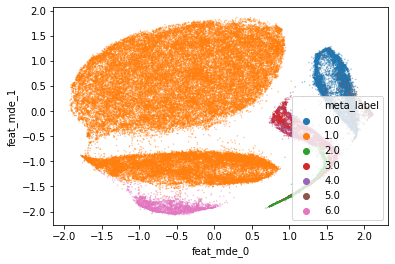

In [39]:
seaborn.scatterplot(data=trans_df, hue="meta_label", x="feat_mde_0", y="feat_mde_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

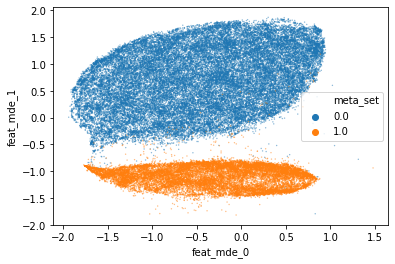

In [40]:
seaborn.scatterplot(data=trans_df[trans_df["meta_label"] == 1], hue="meta_set", x="feat_mde_0", y="feat_mde_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

In [56]:
mde_dist = pymde.preserve_distances(df.drop(columns=["meta_set", "meta_label"]).values, constraint=pymde.Standardized(), max_distances=6000000, device="cuda", verbose=True)

Jun 23 10:42:04 AM: Sampling 6000000 edges
Jun 23 10:42:04 AM: Computing 6000000 distances


In [48]:
m_trans = mde_dist.embed(verbose=True, max_iter=15000)

Jun 23 10:29:26 AM: Fitting a standardized embedding into R^2, for a graph with 80654 items and 5000000 edges.
Jun 23 10:29:26 AM: `embed` method parameters: eps=1.0e-05, max_iter=10000, memory_size=10
Jun 23 10:29:26 AM: iteration 00000 | distortion 1.033646 | residual norm 0.00152301 | step length 99247.3 | percent change 37.635
Jun 23 10:29:53 AM: iteration 01000 | distortion 0.237562 | residual norm 0.000127983 | step length 1 | percent change 0.0373666
Jun 23 10:30:19 AM: iteration 02000 | distortion 0.235954 | residual norm 0.000112932 | step length 1 | percent change 0.0233055
Jun 23 10:30:46 AM: iteration 03000 | distortion 0.235614 | residual norm 9.54039e-05 | step length 1 | percent change 0.002892
Jun 23 10:31:15 AM: iteration 04000 | distortion 0.235395 | residual norm 9.26093e-05 | step length 1 | percent change 0.00276765
Jun 23 10:31:50 AM: iteration 05000 | distortion 0.235269 | residual norm 9.29154e-05 | step length 1 | percent change 0.00257797
Jun 23 10:32:21 AM: i

In [49]:
trans_df["feat_mde_dist_0"] = m_trans[:, 0].cpu().numpy()
trans_df["feat_mde_dist_1"] = m_trans[:, 1].cpu().numpy()

/home/maximl/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


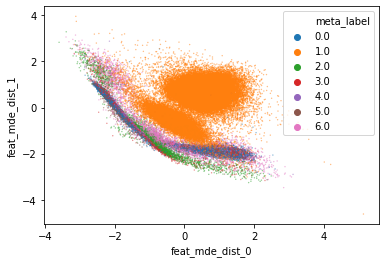

In [50]:
seaborn.scatterplot(data=trans_df, hue="meta_label", x="feat_mde_dist_0", y="feat_mde_dist_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

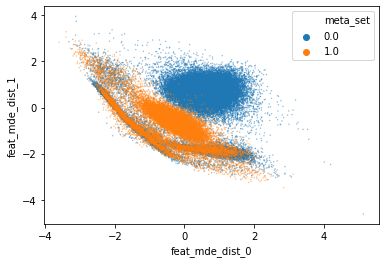

In [51]:
seaborn.scatterplot(data=trans_df, hue="meta_set", x="feat_mde_dist_0", y="feat_mde_dist_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

In [53]:
fcs_data.text["class_labels"]

'CD4+ T|CD8+ T|Neutro|Mono|B|CD56+ NKT|NKT|Eos'

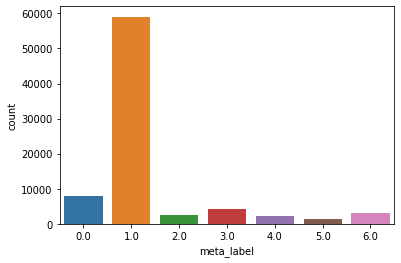

In [55]:
seaborn.countplot(data=df, x="meta_label")

In [54]:
for col in trans_df:
    if(trans_df[col].dtype == numpy.int64):
        trans_df[col] = trans_df[col].astype(numpy.int32)

trans_df.reset_index(drop=True).to_feather("./demo_wbc.feather", compression="uncompressed")